In [ ]:
import pyro.distributions as dist
import pyro.distributions.constraints as constraints

import torch
import numpy as np
import pandas as pd

import pyro

def simple_model(is_cont_africa, ruggedness, log_gdp=None):
    a = pyro.param("a", lambda: torch.randn(()))
    b_a = pyro.param("bA", lambda: torch.randn(()))
    b_r = pyro.param("bR", lambda: torch.randn(()))
    b_ar = pyro.param("bAR", lambda: torch.randn(()))
    sigma = pyro.param("sigma", lambda: torch.ones(()), constraint=constraints.positive)

    mean = a + b_a * is_cont_africa + b_r * ruggedness + b_ar * is_cont_africa * ruggedness

    with pyro.plate("data", len(ruggedness)):
        return pyro.sample("obs", dist.Normal(mean, sigma), obs=log_gdp)

DATA_URL = "https://d2hg8soec8ck9v.cloudfront.net/datasets/rugged_data.csv"
data = pd.read_csv(DATA_URL, encoding="ISO-8859-1")
df = data[["cont_africa", "rugged", "rgdppc_2000"]]
df = df[np.isfinite(df.rgdppc_2000)]
df["rgdppc_2000"] = np.log(df["rgdppc_2000"])
train = torch.tensor(df.values, dtype=torch.float)
is_cont_africa, ruggedness, log_gdp = train[:, 0], train[:, 1], train[:, 2]

pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True)


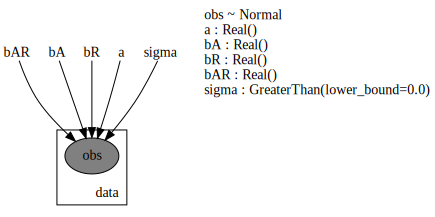

In [3]:
pyro.render_model(simple_model, model_args=(is_cont_africa, ruggedness, log_gdp), render_distributions=True, render_params=True)

In [3]:
# read data
file_fold = 'Dataset/mouse_thymus_rep1/' #please replace 'file_fold' with the download path

adata_omics1 = sc.read_h5ad(file_fold + 'adata_RNA.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'adata_ADT.h5ad')

adata_omics1.var_names_make_unique()
adata_omics2.var_names_make_unique()

In [4]:
# Specify data type
data_type = 'Stereo-CITE-seq'

# Fix random seed
from SpatialGlue.preprocess import fix_seed
random_seed = 2022
fix_seed(random_seed)

In [5]:
from SpatialGlue.preprocess import clr_normalize_each_cell, pca

# RNA
sc.pp.filter_genes(adata_omics1, min_cells=10)
sc.pp.filter_cells(adata_omics1, min_genes=80)

sc.pp.filter_genes(adata_omics2, min_cells=50)
adata_omics2 = adata_omics2[adata_omics1.obs_names].copy()

sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
sc.pp.normalize_total(adata_omics1, target_sum=1e4)
sc.pp.log1p(adata_omics1)

adata_omics1_high =  adata_omics1[:, adata_omics1.var['highly_variable']]
adata_omics1.obsm['feat'] = pca(adata_omics1_high, n_comps=adata_omics2.n_vars-1)

# Protein
adata_omics2 = clr_normalize_each_cell(adata_omics2)
adata_omics2.obsm['feat'] = pca(adata_omics2, n_comps=adata_omics2.n_vars-1)#adata_omics2.obsm['feat']模型的输入

In [6]:
from SpatialGlue.preprocess import construct_neighbor_graph
data = construct_neighbor_graph(adata_omics1, adata_omics2, datatype=data_type)

In [7]:
# define model
from SpatialGlue.SpatialGlue_pyG import Train_SpatialGlue
from SpatialGlue.utils import clustering
from sklearn.preprocessing import OneHotEncoder
from Metric import Moran, calculate_jaccard_similarity
tool = 'mclust' # mclust, leiden, and louvain
model = Train_SpatialGlue(data, datatype=data_type, device=device)
jaccards_omics1 = []
jaccards_omics2 = []
moranIs = []

# train model
output = model.train()
adata = adata_omics1.copy()
adata.obsm['emb_latent_omics1'] = output['emb_latent_omics1']
adata.obsm['emb_latent_omics2'] = output['emb_latent_omics2']
adata.obsm['SpatialGlue'] = output['SpatialGlue']
adata.obsm['alpha'] = output['alpha']
adata.obsm['alpha_omics1'] = output['alpha_omics1']
adata.obsm['alpha_omics2'] = output['alpha_omics2']
clustering(adata, key='SpatialGlue', add_key='SpatialGlue', n_clusters=8, method=tool, use_pca=True)
#
seri = adata.obs['SpatialGlue']
labels = seri.values
labels_array = labels.reshape(-1, 1)  # Reshape for OneHotEncoder
encoder = OneHotEncoder(sparse=False)
one_hot_encoded = encoder.fit_transform(labels_array)
Clust_adata =sc.AnnData(one_hot_encoded)
Clust_adata.obsm['spatial'] = adata.obsm['spatial']
Z_embedding =sc.AnnData(output['SpatialGlue'])
omics1 = sc.AnnData(adata_omics1.obsm['feat'])
omics2 = sc.AnnData(adata_omics2.obsm['feat'])
jaccard_similarities1 = calculate_jaccard_similarity(omics1, Z_embedding, k=50)
jaccard_similarities2 = calculate_jaccard_similarity(omics2, Z_embedding, k=50)
moranI = Moran(Clust_adata)
moranI_mean = moranI.uns['moranI']['I']
jaccards_omics1.append(jaccard_similarities1)
jaccards_omics2.append(jaccard_similarities2)
moranIs.append(moranI_mean)

/opt/anaconda3/envs/smo/lib/python3.12/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


ImportError: cannot import name 'SparseCSCView' from 'anndata._core.views' (/opt/anaconda3/envs/smo/lib/python3.12/site-packages/anndata/_core/views.py)

In [6]:
print('jaccards_omics1:')
print(jaccards_omics1.mean(), jaccards_omics1.std())
print('jaccards_omics2:')
print(jaccards_omics2)
print('moranIs:')
print(moranIs)

jaccards_omics1:


NameError: name 'jaccards_omics1' is not defined